# GTSF phase: biomass prediction

In this notebook, we are forecasting the weights by finding the closest blender model

### Look at the volumes created with blender

Load blender data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
with open("/root/thomas/blender/volumes_all.json", "r") as f:
    data = json.load(f)

Some plot

In [3]:
# plt.scatter(np.array(data["dimensions"])[:, 1], data["volume"])
# plt.ylabel("Volume (cm^3)")
# plt.xlabel("Length (mm)")
# plt.show()

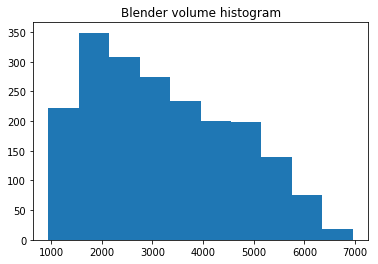

In [4]:
plt.hist(data["volume"])
plt.title("Blender volume histogram")
plt.show()

Calculate pairwise distances from blender data

In [5]:
mapping = data["mapping"]
reverse_mapping = data["reverse_mapping"]

In [6]:
number_of_parts = max(list(mapping.values()))+1

In [7]:
dataset = {"volume":[]}
dataset_np = []
kfactors = []
for (coord, vol) in zip(data["coordinates"], data["volume"]):
    row = []
    for k in range(number_of_parts):
        v = coord[reverse_mapping[str(k)]]
        for k0 in range(k+1, number_of_parts):
            v0 = coord[reverse_mapping[str(k0)]]
            dist = np.sqrt((v[2]-v0[2])**2 + (v[1]-v0[1])**2)
            cname = "{}-{}".format(k, k0)
            row.append(dist)
            if cname not in dataset:
                dataset[cname] = []
            dataset[cname].append(dist)
    dataset_np.append(row)
    dataset["volume"].append(vol)

Create panda dataframe

In [8]:
df = pd.DataFrame(data=dataset)
df.head()

,0-1,0-2,0-3,0-4,0-5,0-6,0-7,1-2,1-3,1-4,...,3-5,3-6,3-7,4-5,4-6,4-7,5-6,5-7,6-7,volume
0,210.696164,85.762188,351.122235,104.673940,231.240474,155.443793,63.171571,295.196907,143.112748,148.643877,...,127.674645,200.138776,406.633746,145.162289,111.082569,142.472777,98.626081,282.727410,215.735159,947.469760
1,210.705475,85.950449,351.189914,106.363262,231.700702,155.521437,63.695112,295.296565,143.388259,150.101572,...,127.906569,200.487039,406.635617,145.225464,113.602803,142.876388,100.537654,282.800882,216.130357,985.368078
2,210.715214,86.145627,351.260100,108.090461,232.177672,155.602191,64.234692,295.400216,143.673877,151.602006,...,128.147268,200.848032,406.637590,145.291195,116.164059,143.294418,102.485876,282.877081,216.540482,1023.265208
3,210.725380,86.347718,351.332793,109.853734,232.671261,155.686036,64.789919,295.507900,143.969542,153.143925,...,128.396706,201.221700,406.639681,145.359474,118.763663,143.726743,104.468680,282.956003,216.965448,1061.176026
4,210.735966,86.556661,351.407960,111.651385,233.181363,155.772966,65.360400,295.619591,144.275171,154.726089,...,128.654813,201.607946,406.641859,145.430288,121.399167,144.173240,106.484148,283.037640,217.405168,1099.083157


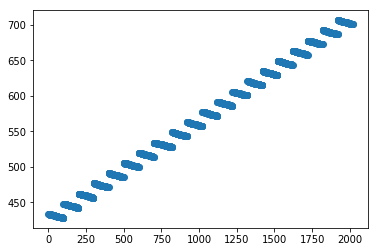

In [9]:
plt.plot(df["2-3"], "o")

## Look at the gtsf data

Loading the gtsf data points and creating the pairwise distances

In [10]:
import json
import os

In [11]:
jsonfiles = ["/root/data/gtsf_phase_I/2019-02-26/2019-02-26_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-02-27/2019-02-27_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-01/2019-03-01_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-04/2019-03-04_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-05/2019-03-05_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-06/2019-03-06_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-11/2019-03-11_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-13/2019-03-13_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-14/2019-03-14_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-18/2019-03-18_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-19/2019-03-19_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-21/2019-03-21_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-25/2019-03-25_cogito_annotations.json",
             "/root/data/gtsf_phase_I/2019-03-27/2019-03-27_cogito_annotations.json"]

In [12]:
annotations = []
for jsonpath in jsonfiles:
    with open(jsonpath, "r") as f:
        jfile = json.load(f)
        annotations += jfile
print("Number of annotations: {}".format(len(annotations)))

Number of annotations: 1091


Add the local path for ease and rename the body parts

In [13]:
for ann in annotations:
    local_path = os.path.join("/root/data/gtsf_phase_I/", 
                  "/".join(ann["Labeled Data"].split("/")[7:]))
    ann["local_path"] = local_path
    if not os.path.isfile(local_path):
        print("missing image!!")
    for body_part in ann["Label"].keys():
        new_body_part = "_".join(body_part.replace(":", "").split()).upper()
        ann["Label"][new_body_part] = ann["Label"].pop(body_part)

### Find ground truth weight

In [14]:
from sqlalchemy import create_engine
from sqlalchemy import MetaData
from sqlalchemy import Table, select, func, and_, insert, delete, update, or_

from tqdm import tqdm

In [15]:
sql_credentials = json.load(open("/root/thomas/sql_research_credentials.json"))

sql_engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(sql_credentials["user"], sql_credentials["password"],
                                         sql_credentials["host"], sql_credentials["port"],
                                         sql_credentials["database"]))

metadata = MetaData()
gtsf = Table('gtsf_data_collections', metadata, autoload=True, autoload_with=sql_engine)

/usr/local/lib/python3.5/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Get all the timestamps

In [16]:
timestamps = []
for ann in annotations:
    timestamp = ann["local_path"].split("/")[-3]
    ann["timestamp"] = timestamp
    timestamps.append(ann["timestamp"])

Query over all the timestamps

In [17]:
query = select([gtsf.c.ground_truth_metadata,
                gtsf.c.gtsf_fish_identifier]).select_from(gtsf).where(gtsf.c.gtsf_fish_identifier.in_(timestamps))
connection = sql_engine.connect()
q = connection.execute(query)
results = [(eval(r[0]), r[1]) for r in q]

Add the morphologic information to the annotations

In [18]:
for r in results:
    print(r[0])
    break

{'fishId': '190226010001', 'time': 1551188021444, 'data': {'weight': 2363, 'length': 591, 'width': 128, 'breath': 67}, 'enclosureId': 1, 'stereoFrames': '1'}


In [19]:
for ann in annotations:
    for r in results:
        if r[1] == ann["timestamp"]:
            ann["weight"] = r[0]["data"]["weight"]
            ann["breath"] = r[0]["data"]["breath"]
            ann["length"] = r[0]["data"]["length"]
            ann["width"] = r[0]["data"]["width"]
            ann["kfactor"] = 10**5*ann["weight"] / ann["length"]**3
            ann["species"] = r[0]["data"].get("species", "salmon")
            break

In [20]:
# [ann for ann in annotations if ann["kfactor"] < 0.6]

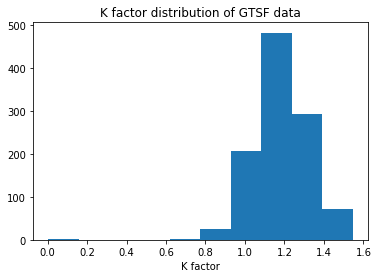

In [21]:
kfactor = np.array([ann["kfactor"] for ann in annotations if ann["species"] == "salmon"])
plt.hist(kfactor)
plt.title("K factor distribution of GTSF data")
plt.xlabel("K factor")
plt.show()

### 2D to 3D 

Move from 2d pixel coordinates to 3d world coordinates. First, need to create pairs

Creating pairs below

In [22]:
# create pairs per timestamp
pairs = {}
for ann in annotations:
    if ann["species"] != "salmon":
        continue
    if ann["kfactor"] < 0.3:
        continue
    timestamp = ann["timestamp"]
    side = os.path.basename(ann["local_path"]).split("_")[0]
    ann["side"] = side
    if timestamp not in pairs:
        pairs[timestamp] = {}
    pairs[timestamp][side] = ann

full_pairs = [k for (k, v)in pairs.items() if "left" in v and "right" in v]
print("Number of full pairs: {}".format(len(full_pairs)))

Number of full pairs: 535


Some plotting

In [23]:
import cv2

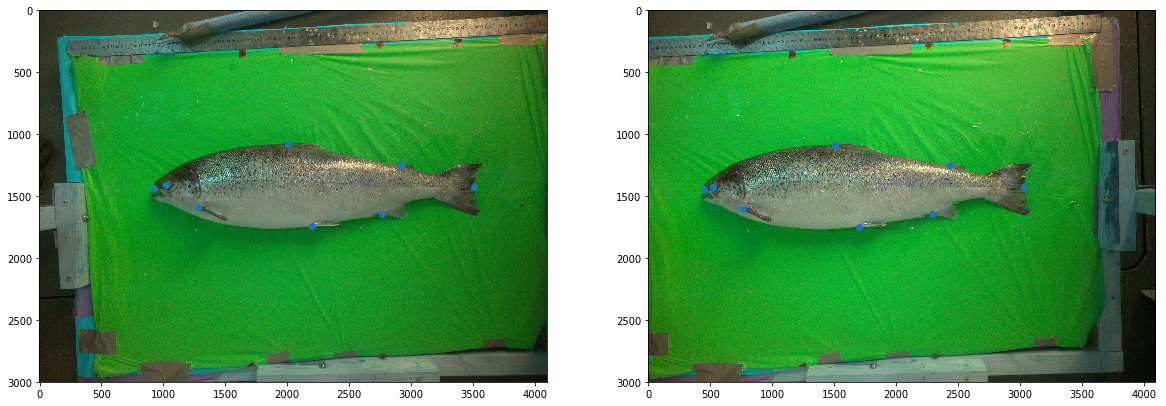

In [24]:
timestamp = np.random.choice(full_pairs)
left_ann = pairs[timestamp]["left"]
right_ann = pairs[timestamp]["right"]

# load images
left_im = cv2.imread(left_ann["local_path"])
right_im = cv2.imread(right_ann["local_path"])

# load keypoints
left_keypoints = [(v[0]["geometry"]["x"], v[0]["geometry"]["y"]) for v in left_ann["Label"].values()]
left_keypoints = np.array(left_keypoints)
right_keypoints = [(v[0]["geometry"]["x"], v[0]["geometry"]["y"]) for v in right_ann["Label"].values()]
right_keypoints = np.array(right_keypoints)

f, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(left_im)
ax[0].scatter(left_keypoints[:, 0], left_keypoints[:, 1])
ax[1].imshow(right_im)
ax[1].scatter(right_keypoints[:, 0], right_keypoints[:, 1])
plt.show()

Match the keypoints and create world coordinates

In [25]:
from utils import depth_from_disp, convert_to_world_point, load_keypoints, euclidean_distance

In [26]:
rescale = False
new_shape = (512, 512)
height_ratio = new_shape[0] / 3000.0
width_ratio = new_shape[1] / 4096.0

In [78]:
# introducing....jittering
jitter = True
jitter_max = 50

In [79]:
def jitter_array(array):
    # randomly pick what part to jitter
    size = array.shape[0]
    coin = np.random.rand(size)
    coin = np.round(coin)
    
    delta = np.random.randint(-jitter_max, jitter_max, size=size)
    array = array + delta*coin
    return array.astype(np.int64)

In [80]:
world = {}
for ts in full_pairs:
    # load annotations
    left_ann = pairs[ts]["left"]
    right_ann = pairs[ts]["right"]
    
    left_keypoints = load_keypoints(left_ann, mapping)
    right_keypoints = load_keypoints(right_ann, mapping)
    if jitter:
        left_keypoints[:, 0] = jitter_array(left_keypoints[:, 0])
        left_keypoints[:, 1] = jitter_array(left_keypoints[:, 1])
        right_keypoints[:, 0] = jitter_array(right_keypoints[:, 0])
        right_keypoints[:, 1] = jitter_array(right_keypoints[:, 1])
    if rescale:
        left_keypoints = left_keypoints * np.array([width_ratio, height_ratio])
        left_keypoints = np.array(left_keypoints, dtype=np.uint8)
        right_keypoints = right_keypoints * np.array([width_ratio, height_ratio])
        right_keypoints = np.array(right_keypoints, dtype=np.uint8)
        
    # calculate disparities
    disparities = left_keypoints[:, 0] - right_keypoints[:, 0]
    # print(disparities)
    # compute world key point
    world_keypoints = {}
    for (i, d) in enumerate(disparities):
        depth = depth_from_disp(d)
        world_coord = convert_to_world_point(left_keypoints[i, 0], left_keypoints[i, 1], depth)
        world_keypoints[list(mapping.keys())[i]] = world_coord
    world[ts] = world_keypoints


Plot world coordinates

In [81]:
# plt.scatter(left_keypoints[:, 0], left_keypoints[:, 1])
# for i in range(number_of_parts):
#     plt.text(left_keypoints[i, 0], left_keypoints[i, 1], list(mapping.keys())[i])
# plt.show()

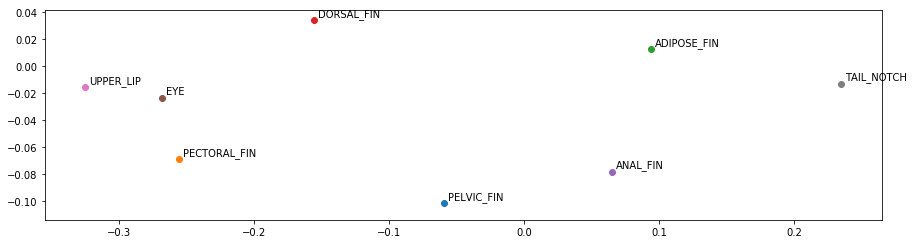

In [82]:
plt.figure(figsize=(15, 10))
for (k, v) in world['190226010005'].items():
    plt.scatter(v[0], v[2])
    plt.text(v[0]+0.003, v[2]+0.003, k)
    plt.axis("scaled")
plt.show()

### Forecasting

First, let's calculate the pairwise distances for the gtsf data. Second let's find the closest Blender model

In [83]:
predictions = []
predictions_average = []
ground_truth = []

for ts in world:
    # load keypoints
    world_keypoints = world[ts]
    # calculate distances
    measurements= []
    for k in range(number_of_parts):
        v = world_keypoints[reverse_mapping[str(k)]]
        for k0 in range(k+1, number_of_parts):
            v0 = world_keypoints[reverse_mapping[str(k0)]]
            dist = euclidean_distance(v, v0)*1000 # mm to m
            measurements.append(dist)
    
    # find closest blender volume
    # calculate l1 distance
    diff = np.nanmean(np.abs(np.array(df)[:, :-1] - measurements), axis=1)
    closest = np.argsort(diff)
    idx = 10
    closest5 = np.array(df)[closest[:idx], -1]
    print("closest volumes", closest5)
    print("standard dev:", np.std(closest5))
    print("estimated length", measurements[13])
    closest_length = np.array(list(df["2-3"].iloc()[closest[:idx]]))
    kfactor = 10**5*closest5 / closest_length**3
    print("closest length", closest_length)
    print("closest kfactor", kfactor)
    print("closest height", list(df["4-6"].iloc()[closest[:idx]]))
    print("#"*50)
    pred_volume = np.array(df)[closest[0], -1]
    predictions.append(pred_volume)
    predictions_average.append(np.mean(closest5))
    
    # ground truth
    ground_truth_weight = [ann["weight"] for ann in annotations if ann["timestamp"] == ts][0]
    ground_truth_kfactor = [ann["kfactor"] for ann in annotations if ann["timestamp"] == ts][0]
    ground_truth.append([ground_truth_weight, ground_truth_kfactor])

closest volumes [2814.27040101 2881.27316056 2897.0269128  2966.00692263 2747.26689146
 2828.05940298 2979.8204246  3050.79693472 2971.31442339 3042.08393347]
standard dev: 95.8060222327964
estimated length 539.9846100840973
closest length [562.91454779 562.9165259  562.31534596 562.31736044 562.91260558
 562.31336737 561.71611456 561.7181655  577.26936304 577.27133428]
closest kfactor [1.57775079 1.61529719 1.62934376 1.66812152 1.54020288 1.5905719
 1.68127766 1.72130526 1.54458952 1.5813617 ]
closest height [169.5572202173334, 172.31849713564884, 169.6301099034802, 172.3902793871593, 166.81686718579886, 166.8908961613312, 169.70306402246584, 172.46212215748204, 170.96377217382886, 173.70264607846607]
##################################################
closest volumes [4275.07110916 4184.1153462  4093.11358324 4002.15707028 4366.03412213
 3911.16830731 4381.94812439 4288.75111111 4195.47709782 4102.20983453]
standard dev: 146.2917228820592
estimated length 620.4505616932513
closest le

closest volumes [3302.80547062 3220.20620885 3137.61519709 3385.34573239 3389.71273301
 3304.95897093 3220.20020885 3467.97749416 3474.46824509 3550.51575592]
standard dev: 124.6147549457266
estimated length 617.5994787188088
closest length [620.33025709 620.32851556 620.32677599 620.33206164 619.73102255
 619.72927586 619.72756175 620.33389869 619.73283225 620.33573782]
closest kfactor [1.3836113  1.34902018 1.31443192 1.41817669 1.42414164 1.38854524
 1.35294593 1.45277958 1.45973773 1.48734267]
closest height [170.05178175577328, 167.45252916928837, 164.87969859377108, 172.67627979778788, 170.13157482867234, 167.53349348161848, 164.96186288741725, 175.3248914706208, 172.75491583212508, 177.99654134392193]
##################################################
closest volumes [3112.80919355 3042.08393347 3201.76320623 2971.31442339 3128.97819586
 2900.5389133  3290.7349689  3056.22168549 2829.79865322 3215.94320825]
standard dev: 137.6829020042338
estimated length 564.4569978436792
close

closest kfactor [1.61529719 1.57775079 1.66812152 1.54020288 1.62934376 1.50265008
 1.72130526 1.5905719  1.50781319 1.46508628]
closest height [172.31849713564884, 169.5572202173334, 172.3902793871593, 166.81686718579886, 169.6301099034802, 164.09849788242252, 172.46212215748204, 166.8908961613312, 168.2463819435504, 161.40320340900175]
##################################################
closest volumes [2881.27316056 2966.00692263 2814.27040101 3050.79693472 2897.0269128
 2747.26689146 2979.8204246  3135.53319679 2828.05940298 3112.80919355]
standard dev: 123.8539046363411
estimated length 527.0256239576702
closest length [562.9165259  562.31736044 562.91454779 561.7181655  562.31534596
 562.91260558 561.71611456 561.11894097 562.31336737 577.27330995]
closest kfactor [1.61529719 1.66812152 1.57775079 1.72130526 1.62934376 1.54020288
 1.68127766 1.77478854 1.5905719  1.61811009]
closest height [172.31849713564884, 172.3902793871593, 169.5572202173334, 172.46212215748204, 169.630109903

 662.81248492 663.40591981 662.81051635 662.80860878 662.2152553 ]
closest kfactor [1.63205333 1.59941078 1.56680483 1.53415734 1.67639525 1.64286542
 1.50152658 1.60934375 1.57585419 1.72096332]
closest height [201.32714153889432, 198.57773478238798, 195.84647478176984, 193.13413296066773, 201.39963574362775, 198.6511801996633, 190.44153969185408, 195.9208917774694, 193.2095450515592, 201.47218700750443]
##################################################
closest volumes [3880.84530299 3982.97406754 3798.22929122 4085.07158209 3612.33151473
 3898.19230546 4187.22934665 3998.1383197  3709.92227864 4289.40711121]
standard dev: 198.733361634854
estimated length 591.1901534348077
closest length [620.34348025 619.74428253 620.34151114 619.14508567 605.98669561
 619.74227756 618.5458897  619.14307534 605.38749828 617.94669464]
closest kfactor [1.62565979 1.6732849  1.59106766 1.7211645  1.62329829 1.63768318
 1.76933869 1.68455329 1.67210855 1.81779216]
closest height [188.89374340215798, 18

closest volumes [2199.4133134  2143.00105536 2086.61067233 2030.18491429 2255.77782143
 2270.3295735  1973.79815625 2212.12281521 1917.39989821 2153.91830692]
standard dev: 113.54710756642145
estimated length 510.89239221198767
closest length [519.84440278 519.842425   519.8405013  519.83863162 519.84638881
 519.24520201 519.83678553 519.24323312 519.83496297 519.24128787]
closest kfactor [1.56562134 1.52548248 1.48535782 1.44520663 1.60572522 1.62170341
 1.40508214 1.58014412 1.36494843 1.53858528]
closest height [157.12189028788433, 154.37663178904046, 151.6549843683597, 148.95820885533206, 159.88951940886415, 157.19447804716106, 146.2877069468155, 154.4504471784407, 143.64492481805578, 151.73005100585237]
##################################################
closest volumes [2030.18491429 1973.79815625 2086.61067233 1917.39989821 2095.70479862
 2143.00105536 2037.46391532 2153.91830692 1860.98526518 2153.89530691]
standard dev: 96.49680302389675
estimated length 497.1655476018165
close

closest kfactor [1.62565979 1.6732849  1.76811414 1.72111505 1.67438326 1.81536865
 1.62789915 1.86286176 1.59106766 1.7211645 ]
closest height [188.89374340215798, 188.96595968232148, 193.25516004968998, 193.18274030654598, 193.11036795749604, 193.32763666812087, 193.03805499220618, 193.400161857682, 186.1396908887061, 189.03823089505653]
##################################################
closest volumes [1974.38128133 2036.07941513 1914.54314781 2034.21991486 1974.37428133
 2097.79329892 2097.78954892 2034.21378986 2161.36480798 2094.06304839]
standard dev: 69.80740071782773
estimated length 530.3524656657859
closest length [534.18819551 533.58895195 534.18651431 534.18992969 533.5872496
 532.98969406 533.59070734 532.98800107 532.99145538 534.19171693]
closest kfactor [1.29523379 1.34021424 1.25599063 1.33447614 1.29961033 1.38549914
 1.38082024 1.3435205  1.42747114 1.37372026]
closest height [142.59140842662615, 142.67310957555307, 140.03769818931727, 145.17676185823524, 140.12081

closest volumes [2273.55157396 2213.72931544 2333.39733249 2344.60808409 2153.89530691
 2393.23759102 2407.94859311 2282.9043253  2406.31159288 2344.57733408]
standard dev: 80.0906576266455
estimated length 519.5218499957015
closest length [534.19725933 534.19535887 534.19918234 533.59804588 534.19351139
 534.20112783 548.55204035 533.59612405 533.59995976 548.55017633]
closest kfactor [1.49141959 1.45219248 1.53066108 1.54321902 1.41295641 1.56989792
 1.45879312 1.50262189 1.58381517 1.42041577]
closest height [155.80279381452684, 153.1065472403209, 158.52330266607746, 155.87790275741685, 150.4358436241593, 161.26683442605872, 157.2548628051204, 153.1829106051617, 158.59719301053985, 154.58399590855]
##################################################
closest volumes [4162.3020931  4075.55608074 4457.02963509 4269.04160831 4366.03412213
 4180.10909563 4568.43315097 3988.85831838 4275.07110916 4475.17663768]
standard dev: 176.2197809244792
estimated length 614.3752432824316
closest leng

closest volumes [2685.0673826  2759.64189323 2759.64164323 2834.23540386 2836.31315415
 2834.24115386 2912.96091507 2908.82441449 2912.95491507 2908.84691449]
standard dev: 75.43072365642632
estimated length 590.2289858356271
closest length [591.61331696 591.0140708  591.61501765 590.41482544 591.0157768
 591.61678289 590.41653677 589.81555042 591.01751691 591.61858227]
closest kfactor [1.29670554 1.33677793 1.33270836 1.37709581 1.3739058  1.3687223
 1.41533458 1.41764944 1.41101849 1.40473838]
closest height [156.59732978056542, 156.67978161923526, 159.16448325576616, 156.7622860667199, 159.24566812609905, 161.75958818808365, 159.32690888732645, 156.84484591240846, 161.83954071601306, 164.38135651131367]
##################################################
closest volumes [2512.89935807 2453.06359954 2393.23759102 2333.39733249 2273.55157396
 2407.94859311 2471.35385215 2534.72036118 2598.10237021 2591.42436926]
standard dev: 101.37511120122186
estimated length 506.45052028111945
close

closest volumes [2281.21632506 2217.84406603 2154.490807   2091.12117297 2344.57733408
 2278.17157462 2350.35783491 2407.94859311 2285.07557561 2415.64684421]
standard dev: 99.5706371980751
estimated length 534.7019874245184
closest length [548.54837959 548.54661962 548.54489639 548.54314894 548.55017633
 562.89989117 547.94914836 548.55204035 547.94735205 547.95098147]
closest kfactor [1.38204334 1.34366306 1.3052933  1.26691306 1.42041577 1.27730007
 1.42860846 1.45879312 1.38894187 1.46827808]
closest height [151.93931879872397, 149.3222458300512, 146.7342395392424, 144.17687147956843, 154.58399590855, 148.31656626703966, 152.01822678618274, 157.2548628051204, 149.40247151717855, 154.66161864350238]
##################################################
closest volumes [3112.80919355 3201.76320623 3290.7349689  3042.08393347 3379.67073158
 3128.97819586 3468.63999425 3215.94320825 2971.31442339 2881.27316056]
standard dev: 171.75415808297737
estimated length 548.6190952213705
closest le

In [84]:
predictions = np.array(predictions)
predictions_average = np.array(predictions_average)
ground_truth = np.array(ground_truth)
gt_weight = ground_truth[:, 0]
gt_kfactor = ground_truth[:, 1]

**OLD CODE**

Quick OLS. 

$\hat{\beta} = (X^{T}X)^{-1}X^{T}Y$

(just for Alok)

In [85]:
# ground_truth = ground_truth[:, np.newaxis]
# ground_truth.shape
# A = np.linalg.inv(np.matmul(ground_truth.transpose(), ground_truth))
# B = np.matmul(ground_truth.transpose(), predictions)
# coeff = 1 / (A*B)
# print("Reg coeff: {}".format(coeff))
# plt.figure(figsize=(10, 10))
# plt.plot([0, 5000], [0, 5000], "--", c="r", linewidth=2)
# plt.scatter(ground_truth, predictions*coeff)
# #plt.scatter(ground_truth, predictions)
# plt.xlabel("Ground truth weight")
# plt.ylabel("Predicted weight")
# plt.axis("scaled")
# plt.show()

**Linear reg New code**

In [86]:
from sklearn.linear_model import LinearRegression

In [87]:
predictions = predictions[:, np.newaxis]
reg = LinearRegression().fit(predictions, gt_weight)
print(reg.coef_, reg.intercept_)
print("R2 : {}".format(reg.score(predictions, gt_weight)))
predictions = np.squeeze(predictions)

[0.60755138] 376.50502782935155
R2 : 0.734792757036911


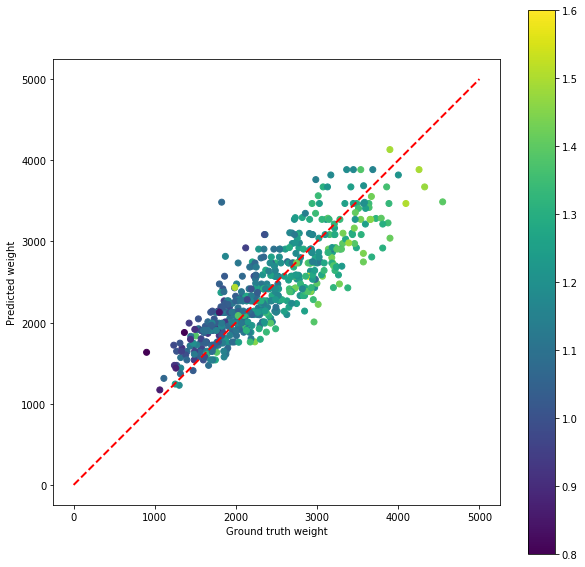

In [88]:
plt.figure(figsize=(10, 10))
plt.plot([0, 5000], [0, 5000], "--", c="r", linewidth=2)
plt.scatter(gt_weight, predictions*reg.coef_ + reg.intercept_, c=gt_kfactor)
#plt.scatter(ground_truth, predictions)
plt.xlabel("Ground truth weight")
plt.ylabel("Predicted weight")
plt.colorbar()
plt.clim([0.8, 1.6])
plt.axis("scaled")
plt.show()

In [89]:
fitted_predictions = predictions*reg.coef_ + reg.intercept_
error = fitted_predictions-gt_weight
print("Average absolute error: {}".format(np.nanmean(np.abs(error))))
print("Average error: {}".format(np.nanmean(error)))
# error5 = predictions_average-ground_truth
#print("Average absolute error5: {}".format(np.nanmean(np.abs(error5))))
relative_error = ((fitted_predictions-gt_weight) / gt_weight)*100
print("Average relative error: {} %".format(np.nanmean(relative_error)))

Average absolute error: 266.28978038338585
Average error: -1.3897419041109698e-13
Average relative error: 2.0529038046920447 %


In [90]:
from scipy.stats.kde import gaussian_kde

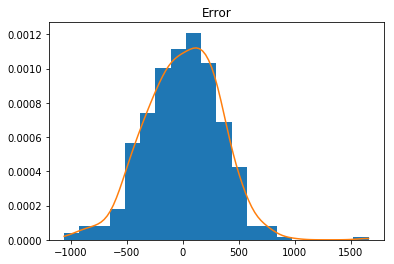

In [91]:
kde = gaussian_kde(error)
dist_space = np.linspace( min(error), max(error), 100 )
plt.hist(error, bins=20, density=True)
plt.plot( dist_space, kde(dist_space) )
plt.title("Error")
plt.show()

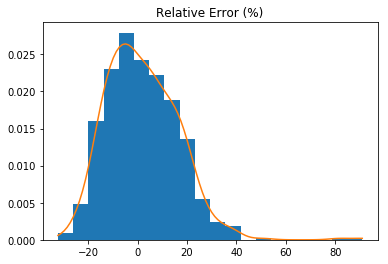

In [92]:
kde = gaussian_kde(relative_error)
dist_space = np.linspace( min(relative_error), max(relative_error), 100 )
plt.hist(relative_error, bins=20, density=True)
plt.plot( dist_space, kde(dist_space) )
plt.title("Relative Error (%)")
plt.show()

**Percentile plot**

In [93]:
values = np.arange(0, 101, 5)
percentiles = np.percentile(np.abs(relative_error), values)

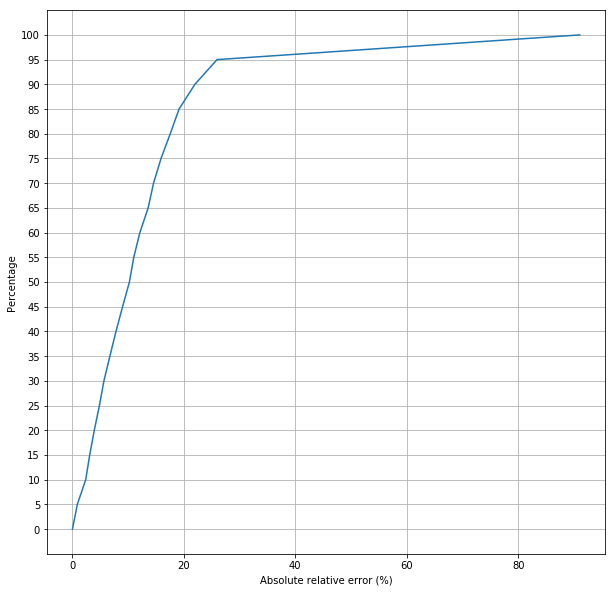

In [94]:
plt.figure(figsize=(10,10))
plt.plot(percentiles, values)
plt.yticks(np.arange(0,101,5))
plt.ylabel("Percentage")
plt.xlabel("Absolute relative error (%)")
plt.grid()
plt.show()

**KS test**

In [95]:
from scipy.stats import kstest
from scipy.optimize import curve_fit
from scipy.stats import norm

Mean: 2393.3439252336448, Standard deviation: 555.5941295413663


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


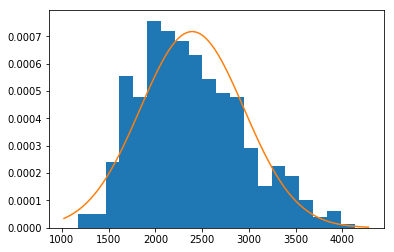

In [96]:
mean, std = norm.fit(fitted_predictions)
print("Mean: {}, Standard deviation: {}".format(mean, std))
plt.hist(fitted_predictions, bins=20, normed=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y)
plt.show()

In [97]:
kstest(fitted_predictions, norm(loc=mean, scale=std).cdf)

KstestResult(statistic=0.07895862185753877, pvalue=0.002388825841108446)

**Cross validation**

In [98]:
from sklearn.model_selection import train_test_split

In [99]:
# predictions = np.squeeze(predictions)
# all_errors = []
# for i in np.arange(0.1, 1.0, 0.1):
#     predictions = predictions[:, np.newaxis]
#     test_size = i
#     print(test_size)
#     X_train, X_test, y_train, y_test = train_test_split(predictions, ground_truth, test_size=test_size)
#     X_test= np.squeeze(X_test)
    
#     plt.scatter(X_train, y_train)
#     plt.scatter(X_test, y_test)
#     plt.axis("scaled")
#     plt.show()
    
#     reg = LinearRegression().fit(X_train, y_train)
#     print(reg.coef_, reg.intercept_)
#     print("R2 : {}".format(reg.score(X_train, y_train)))
#     predictions = np.squeeze(predictions)
    
    
#     fitted_X_test = X_test*reg.coef_ + reg.intercept_
#     error = fitted_X_test-y_test
#     print("Average absolute error: {}".format(np.nanmean(np.abs(error))))
#     print("Average error: {}".format(np.nanmean(error)))
#     relative_error = ((fitted_X_test-y_test) / y_test)*100
#     print("Average relative error: {} %".format(np.nanmean(relative_error)))
#     all_errors.append(np.nanmean(relative_error))
#     print("#"*50)
# plt.plot(np.arange(0.1, 1.0, 0.1)*100 , all_errors)
# plt.ylabel("Test set average relative error")
# plt.xlabel("Test set size (% of total pop)")
# plt.show()

In [100]:
predictions = np.squeeze(predictions)
all_errors = []
all_relative_errors = []
for i in range(1000):
    predictions = predictions[:, np.newaxis]
    test_size = i
    X_train, X_test, y_train, y_test = train_test_split(predictions, gt_weight, test_size=0.2)
    X_test= np.squeeze(X_test)
    
    reg = LinearRegression().fit(X_train, y_train)
    # print(reg.coef_, reg.intercept_)
    # print("R2 : {}".format(reg.score(X_train, y_train)))
    predictions = np.squeeze(predictions)
    
    
    fitted_X_test = X_test*reg.coef_ + reg.intercept_
    error = fitted_X_test-y_test
    relative_error = ((fitted_X_test-y_test) / y_test)*100
    all_errors.append(np.nanmean(error))
    all_relative_errors.append(np.nanmean(relative_error))


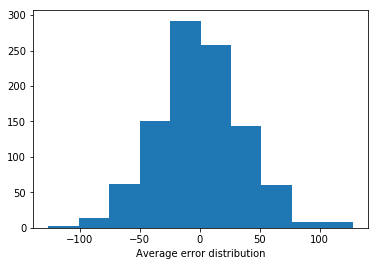

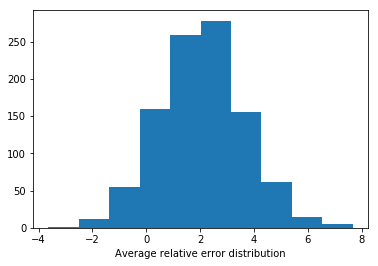

In [101]:
plt.hist(all_errors)
plt.xlabel("Average error distribution")
plt.show()
plt.hist(all_relative_errors)
plt.xlabel("Average relative error distribution")
plt.show()